In [7]:
from setuptools import distutils
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from scipy import signal
import sigmf

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.17.0


In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Introduction

In this notebook, we will implement the RFFI algorithm based on the [Liverpool LoRa RFFI paper](https://livrepository.liverpool.ac.uk/3112081/1/INFOCOM2021_RFFI_LoRa.pdf). It will consist of a CNN model that will be trained on the LoRa dataset. Furthermore, CFO estimation will be performed at the same time, to also apply the hybrid classifier to the CNN predictions. Lastly, we will evaluate the performance of the RFFI algorithm on the LoRa dataset, and maybe on our own dataset.


## Input preparation

The input data will be the raw IQ samples of the LoRa dataset. The IQ samples will be converted to spectrograms, which will be the input to the CNN model. The CNN model will be trained on the LoRa dataset, and the performance will be evaluated on the LoRa dataset.

In [9]:
# Read the IQ samples from the file
def load_iq_samples(file, dataset_name='data', labelset_name='label', dev_range=range(10), pkt_range=slice(0, 10)):
  f = h5py.File(file, 'r')
  label = f[labelset_name][:]
  label = label.astype(int)
  label = np.transpose(label)
  label = label - 1

  label_start = int(label[0]) + 1
  label_end = int(label[-1]) + 1
  num_dev = label_end - label_start + 1
  num_pkt = len(label)
  num_pkt_per_dev = int(num_pkt / num_dev)

  print('Dataset information: Dev ' + str(label_start) + ' to Dev ' +
            str(label_end) + ', ' + str(num_pkt_per_dev) + ' packets per device.')

  sample_index_list = []

  for dev_idx in dev_range:
      sample_index_dev = np.where(label == dev_idx)[0][pkt_range].tolist()
      sample_index_list.extend(sample_index_dev)

  data = f[dataset_name][sample_index_list]
  data = _convert_to_complex(data)

  label = label[sample_index_list]

  f.close()
  return data, label

def _convert_to_complex(data):
  num_row = data.shape[0]
  num_col = data.shape[1]
  data_complex = np.zeros([num_row, round(num_col / 2)], dtype=complex)

  data_complex = data[:, :round(num_col / 2)] + 1j * data[:, round(num_col / 2):]
  return data_complex


Dataset information: Dev 1 to Dev 30, 500 packets per device.


/tmp/ipykernel_206776/1069489063.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_start = int(label[0]) + 1
/tmp/ipykernel_206776/1069489063.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_end = int(label[-1]) + 1


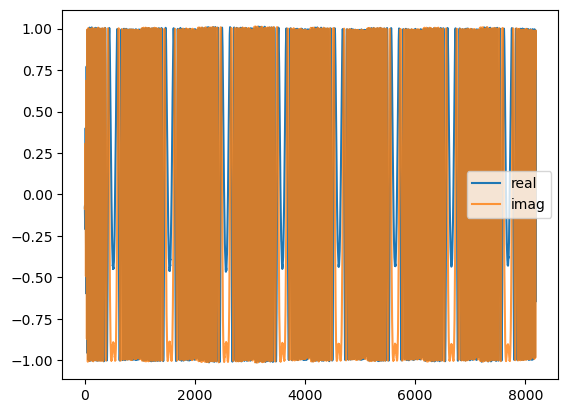

In [10]:
# Data from the LoRaRffi dataset is already CFO compensated
file = '/home/kazawai/Documents/Datasets/LoRaRffi/LoRa_RFFI/dataset/Train/dataset_training_no_aug.h5'

data_, label_ = load_iq_samples(file, dev_range=range(0,10), pkt_range=range(0,500))

data = data_[0, :]

# Normalize the data
data = data / np.sqrt(np.mean(np.abs(data)**2))

# Plot the data
plt.plot(data.real, label='real')
plt.plot(data.imag, label='imag', alpha=.8)
plt.legend()
plt.show()

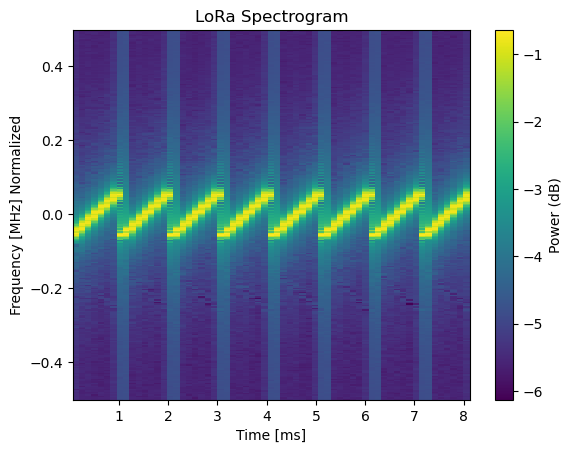

In [11]:
# Plot the spectrogram
f, t, spec = signal.stft(data,
                         window='boxcar',
                         nperseg=256,
                         noverlap=128,
                         nfft=256,
                         return_onesided=False,
                         padded=False,
                         boundary=None)

# Shift the spectrum to the center
spec = np.fft.fftshift(spec, axes=0)

# Take the lograthm to plot into lograthmic scale
spec_db =  np.log10(np.abs(spec)**2)

# Shift the frequency to the center
f = np.fft.fftshift(f, axes=0)

fig, ax = plt.subplots()
im = plt.pcolor(t/1000, f, spec_db, shading='auto')
plt.colorbar(im).set_label('Power (dB)')
plt.xlabel('Time [ms]')
plt.ylabel('Frequency [MHz] Normalized')
plt.title('LoRa Spectrogram')
plt.show()

In [12]:
def build_cnn_model(input_shape):
  inputs = tf.keras.layers.Input(shape=input_shape),

  x = tf.keras.layers.Conv2D(filters=32, kernel_size=(7, 7), strides=2, activation='relu', padding='same')(inputs)

  x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)

  x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)

  x = tf.keras.layers.AveragePooling2D(pool_size=2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512)(x)

  outputs = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)

  model = tf.keras.Model(inputs=inputs[0], outputs=outputs)

  return model

# model = build_cnn_model(input_shape=(1024, 2, 1))